# Import libraries

In [ ]:
from time import time
from PIL import Image
import cv2
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import os
import pickle
import tensorflow as tf
from tensorflow import keras
from skimage import io 
from keras import Model
from keras import Input
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data loading

Importing the training dataset and convert to the desidered input dimension of the network

In [ ]:
train_labels = pd.read_csv('train.csv')
train_labels['Classes'] = train_labels['Classes'].replace('F-16A/B', 'F-16AB')
train_labels['Classes'] = train_labels['Classes'].replace('F/A-18', 'FA-18')

In [ ]:
train_labels.head()

filename  Classes  Labels
0  1025794.jpg  707-320       0
1  1340192.jpg  707-320       0
2  0056978.jpg  707-320       0
3  0698580.jpg  707-320       0
4  0450014.jpg  707-320       0

In [ ]:
similarity_df = pd.DataFrame(train_labels, columns=['filename','Classes','Labels'])
similarity_df['Similarity'] = np.nan
similarity_df.head()

filename  Classes  Labels  Similarity
0  1025794.jpg  707-320       0         NaN
1  1340192.jpg  707-320       0         NaN
2  0056978.jpg  707-320       0         NaN
3  0698580.jpg  707-320       0         NaN
4  0450014.jpg  707-320       0         NaN

In [ ]:
test_labels = pd.read_csv('test.csv')
test_labels['Classes'] = test_labels['Classes'].replace('F-16A/B', 'F-16AB')
test_labels['Classes'] = test_labels['Classes'].replace('F/A-18', 'FA-18')

In [ ]:
test_labels.head()

filename  Classes  Labels
31  0939480.jpg  707-320       0
15  0894381.jpg  707-320       0
26  0197342.jpg  707-320       0
17  0447936.jpg  707-320       0
8   1453508.jpg  707-320       0

# Definition network and feature extraction train

In [ ]:
temp = keras.models.load_model('Model/densenet201.h5')
temp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1920)       0     

In [ ]:
layer_name = 'dense_1'
newmodel = Model(inputs=temp.input, outputs=temp.get_layer(layer_name).output)
newmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1920)       0     

In [ ]:
train_newnet = np.load('Feature extraction/train_newnet_complete_dense.npy')

In [ ]:
mu_array = np.load('Feature extraction/mu_vector.npy')
mu_array.shape

(512,)

In [ ]:
std_array = np.load('std_vector.npy')
std_array.shape

(512,)

(array([11., 29., 61., 96., 98., 88., 63., 47., 16.,  3.]),
 array([-0.38872272, -0.30424508, -0.21976744, -0.13528979, -0.05081215,
         0.03366549,  0.11814313,  0.20262077,  0.2870984 ,  0.37157607,
         0.4560537 ], dtype=float32),
 <a list of 10 Patch objects>)

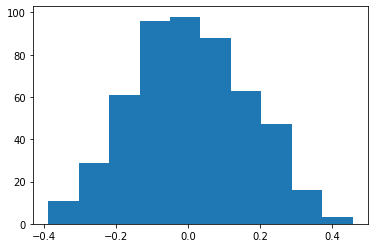

In [ ]:
plt.hist(mu_array)

(array([  1.,   0.,   2.,   8.,  27.,  69., 180., 156.,  59.,  10.]),
 array([0.6704252 , 0.68935776, 0.70829034, 0.7272229 , 0.7461555 ,
        0.7650881 , 0.7840206 , 0.8029532 , 0.82188576, 0.84081835,
        0.8597509 ], dtype=float32),
 <a list of 10 Patch objects>)

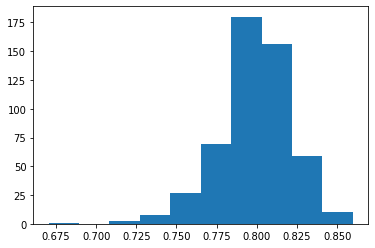

In [ ]:
plt.hist(std_array)

(array([1338.,  206.,  153.,  129.,  115.,   93.,  123.,  149.,  230.,
         798.]),
 array([-9.9999881e-01, -8.0000460e-01, -6.0001034e-01, -4.0001613e-01,
        -2.0002191e-01, -2.7686357e-05,  1.9996653e-01,  3.9996076e-01,
         5.9995496e-01,  7.9994923e-01,  9.9994344e-01], dtype=float32),
 <a list of 10 Patch objects>)

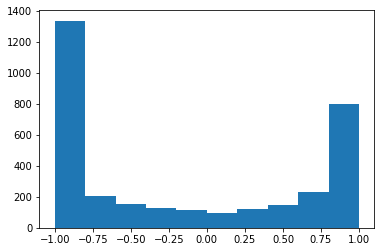

In [ ]:
plt.hist(train_newnet[:,2])

In [ ]:
def normalizeFeatureMatrix(feat_matrix):

  for i in range(0,feat_matrix.shape[1]):

    # 1.normalizing
    feat_matrix[:,i] = (feat_matrix[:,i] - mu_array[i]) / (3 * std_array[i]) 

    # 2.force outliers < -1 to -1 and > 1 to 1
    feat_matrix[:,i] = np.clip(feat_matrix[:,i], -1, 1)

    # 3.[0,1] range
    feat_matrix[:,i] = (feat_matrix[:,i] + 1) / 2

  return feat_matrix

In [ ]:
train_newnet = normalizeFeatureMatrix(train_newnet)

(array([1037.,  247.,  156.,  131.,  130.,  127.,  137.,  145.,  191.,
        1033.]),
 array([0.29841423, 0.33932716, 0.38024008, 0.421153  , 0.46206594,
        0.50297886, 0.5438918 , 0.5848047 , 0.62571764, 0.66663057,
        0.7075435 ], dtype=float32),
 <a list of 10 Patch objects>)

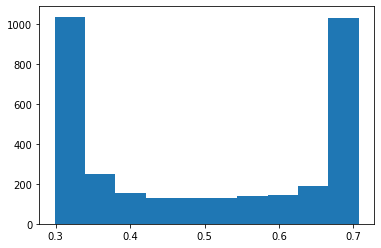

In [ ]:
plt.hist(train_newnet[:,33])

# Feature extraction query

Use the estimated network as feature extractor for each image

In [ ]:
def mobilenet_features(img):
    x = kimage.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    f = newmodel.predict(x, verbose=False)
    return f

Normalizing features using the following formula:

f' = (f - mu) / 3 * sigma

Forcing the features in the [0,1] range

f' = (f + 1) / 2

In [ ]:
def normalizeFeatureVector(feat_array):

  for i in range(0, len(feat_array)):

    # 1.normalizing
    feat_array[:,i] = (feat_array[:,i] - mu_array[i]) / (3 * std_array[i]) 

    # 2.force outliers < -1 to -1 and > 1 to 1
    feat_array[:,i] = np.clip(feat_array[:,i], -1, 1)

    # 3.[0,1] range
    feat_array[:,i] = (feat_array[:,i] + 1) / 2

  return feat_array

In [ ]:
def getFeatureVector(img_name):

  # Load file and extract features
  img_path = 'images/'+img_name
  image = kimage.load_img(img_path, target_size=(224, 224))
  features = mobilenet_features(image)

  features = np.array(features)
  return normalizeFeatureVector(features)

# Evaluation results with test query

Evaluate distance between each image and the query one using Minkowski:

D(I,Q) = sum (wi * |fi(image) - fi(query)|)

In [ ]:
def getMinkowskiSimilarity(A, B, weights=None):
  if weights is None:
    return sum(abs(a-b) for a,b in zip(A, B))
  else:
    return sum(w*abs(a-b) for a,b,w in zip(A, B, weights))

Find best N results more similar to the query image

In [ ]:
def getQueryLabel(img_name, train=False):
  if train:
    df_labels = train_labels
  else:
    df_labels = test_labels

  df_labels = df_labels.reset_index()
  return df_labels[df_labels['filename']==img_name]['Classes'].values[0]

In [ ]:
# Plot similar N images with given image and similar images dataframe
def plotSimilarImages(img_file, similar_df, number_retrieved):
  img = kimage.load_img('images/' + img_file, target_size=(224, 224))

  img_class = getQueryLabel(img_file)
  fig, axarr = plt.subplots(2,3,figsize=(15, 8))
  axarr[0,0].imshow(img)
  axarr[0,0].set_title("TEST IMAGE - " + "\nClass: " + img_class)
  axarr[0,0].axis('off')

  j, k, m = 0, 0, 1
  for index, sim in similar_df.iterrows():
    sim_class = getQueryLabel(sim['filename'], train=True)
    similarity = sim['Similarity']

    similar = kimage.load_img('images/' + sim['filename'], target_size=(224, 224))
    axarr[k,m].imshow(similar)
    axarr[k,m].set_title("Similarity: %.2f" % similarity + "\nClass: " + sim_class)
    axarr[k,m].axis('off')

    m += 1
    if m == 3 and k != 1:
      k += 1
      m = 0

    j += 1
    if j == 5:
      break

  plt.tight_layout()
  plt.show()

In [ ]:
def evaluate(sim_df, query_class, number_retrieved):
  accuracy = 0
  for i in sim_df['Classes'][0:number_retrieved].values:
    if i == query_class:
      accuracy += 1
  return accuracy/number_retrieved*100

In [ ]:
# Get and plot similar images for given image path and features dataframe
def getSimilarImages(img_file, number_retrieval, evaluation=False):
  img_features = getFeatureVector(img_file)
  img_features = img_features[0, :]

  for i in range(0,similarity_df.shape[0]):
    similarity_df.loc[i,'Similarity'] = getMinkowskiSimilarity(img_features, train_newnet[i,:])

  sorted_df = similarity_df.sort_values(by='Similarity', ascending=True)

  if evaluation:
    return evaluate(sorted_df, getQueryLabel(img_file), number_retrieval)

  plotSimilarImages(img_file, sorted_df.head(number_retrieval), number_retrieval)

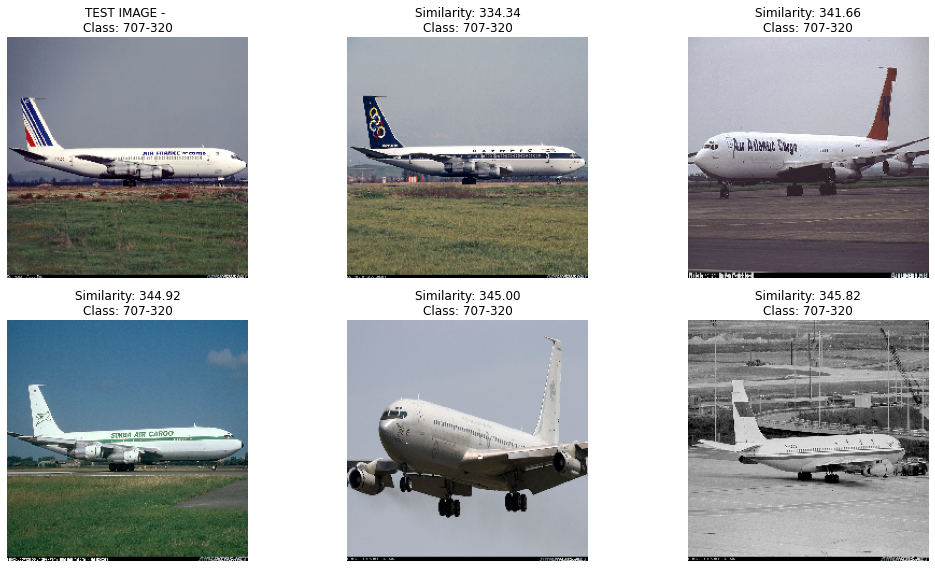

In [ ]:
# Get similar images of test image
t0 = time()
getSimilarImages(test_labels['filename'][0], 10)
print("Time required: %0.2f seconds." % (time() - t0))

# Rebalancing - strategy 1

Update weights type 1

w' = (e + sigma(retrieved images)) / (e + sigma(relevant images))

e = 0.0001

In [ ]:
def getWeightsRF_type1(query_features, retrieval_features, query_name, eps=0.0001):

  retrieval_features.loc[:,('index')] = retrieval_features.index

  # recognise relevant and retrieved documents
  relevant_imgs = []
  retrieval_imgs = []
  for i in range(0,retrieval_features.shape[0]):
    if retrieval_features['Classes'].to_list()[i] == query_name:
      relevant_imgs.append(retrieval_features['index'].to_list()[i])
    retrieval_imgs.append(retrieval_features['index'].to_list()[i])

  if len(relevant_imgs)>3:

    relevant_features = train_newnet[relevant_imgs]
    retrieval_features = train_newnet[retrieval_imgs]

    new_weights = []
    for i in range(0,query_features.shape[0]):
      new_weights.append((eps + np.std(retrieval_features[:,i])) / (eps + np.std(relevant_features[:,i])))

    return new_weights

  else:
    return [1 for i in range(0,retrieval_features.shape[0])]

In [ ]:
# Get and plot similar images for given image path and features dataframe
def getSimilarImages_RF_type1(img_file, num_rounds, number_retrieval, evaluation=False):

  df_output = pd.DataFrame([img_file], columns=['filename'])

  img_features = getFeatureVector(img_file)
  img_features = img_features[0, :]

  for i in range(0,similarity_df.shape[0]):
    similarity_df.loc[i,'Similarity'] = getMinkowskiSimilarity(img_features, train_newnet[i,:])

  sorted_df = similarity_df.sort_values(by='Similarity', ascending=True)

  if evaluation:
    df_output['Evaluation_0'] = evaluate(sorted_df, getQueryLabel(img_file), number_retrieval)
  else:
    plotSimilarImages(img_file, sorted_df.head(number_retrieval), number_retrieval)

  j = 1
  while j <= num_rounds:

    if j == 1:
      tmp_weights = getWeightsRF_type1(img_features, sorted_df.head(number_retrieval), getQueryLabel(img_file))
      old_weights = [1 for i in range(0,len(tmp_weights))]
      new_weights = [0.9*x[0] + 0.1*x[1] for x in zip(old_weights, tmp_weights)]
    else:
      tmp_weights = getWeightsRF_type1(img_features, sorted_df.head(number_retrieval), getQueryLabel(img_file))
      old_weights = new_weights
      new_weights = [0.9*x[0] + 0.1*x[1] for x in zip(old_weights, tmp_weights)]

    for i in range(0,similarity_df.shape[0]):
      similarity_df.loc[i,'Similarity'] = getMinkowskiSimilarity(img_features, train_newnet[i,:], new_weights)

    sorted_df = similarity_df.sort_values(by='Similarity', ascending=True)

    if evaluation:
      df_output['Evaluation_' + str(j)] = evaluate(sorted_df, getQueryLabel(img_file), number_retrieval)
    else:
      print('New iteration')
      plotSimilarImages(img_file, sorted_df.head(number_retrieval), number_retrieval)

    j += 1
  
  return df_output

In [ ]:
t0 = time()

df_type1 = pd.DataFrame()

for name in test_labels['filename']:
  df_type1_new = getSimilarImages_RF_type1(name, 5, 20, evaluation=True)
  df_type1 = df_type1.append(df_type1_new, ignore_index=True)

print("Time required: %0.2f seconds." % (time() - t0))

In [ ]:
df_type1.head()

filename  Evaluation_0  Evaluation_1  Evaluation_2  Evaluation_3  \
0  0939480.jpg         100.0         100.0         100.0         100.0   
1  0894381.jpg          90.0          90.0          90.0          90.0   
2  0197342.jpg          95.0          95.0         100.0          95.0   
3  0447936.jpg          95.0         100.0         100.0         100.0   
4  1453508.jpg          90.0         100.0         100.0         100.0   

   Evaluation_4  Evaluation_5  
0         100.0         100.0  
1          95.0          95.0  
2         100.0         100.0  
3         100.0         100.0  
4         100.0         100.0

# Rebalancing - strategy 2

Update weights type 2

sigma = 1 - (no. of non-relevant images located inside the dominant range of relevant samples) /
(total no. non-relevant images among the retrieved images)

PS The dominant range of a feature component is found by the minimum and maximum values from the
set of relevant samples.

w' = sigma / (e + sigma(relevant images)) 

In [ ]:
def getWeightsRF_type2(query_features, retrieval_features, query_name, eps=0.0001):

  retrieval_features.loc[:,('index')] = retrieval_features.index

  # recognise relevant and retrieved documents
  relevant_imgs = []
  norelevant_imgs = []
  retrieval_imgs = []

  for i in range(0,retrieval_features.shape[0]):
    if retrieval_features['Classes'].to_list()[i] == query_name:
      relevant_imgs.append(retrieval_features['index'].to_list()[i])
    else:
      norelevant_imgs.append(retrieval_features['index'].to_list()[i])
    retrieval_imgs.append(retrieval_features['index'].to_list()[i])

  if len(relevant_imgs)>3 and len(norelevant_imgs)>3:

    relevant_features = train_newnet[relevant_imgs]
    norelevant_features = train_newnet[norelevant_imgs]
    retrieval_features = train_newnet[retrieval_imgs]
    
    new_weights = []
    for i in range(0,query_features.shape[0]):

      min_rel = np.argmin(relevant_features[:,i])
      max_rel = np.argmax(relevant_features[:,i])

      phi = 0
      for norel in range(0,norelevant_features.shape[0]):
        if norelevant_features[norel, i] >= min_rel and norelevant_features[norel, i] <= max_rel:
          phi += 1
      
      F = norelevant_features.shape[0]
      delta = 1 - (phi/F)

      new_weights.append(delta / (eps + np.std(relevant_features[:,i])))

    return new_weights

  else:
    return [1 for i in range(0,retrieval_features.shape[0])]

In [ ]:
# Get and plot similar images for given image path and features dataframe
def getSimilarImages_RF_type2(img_file, num_rounds, number_retrieval, evaluation=False):

  df_output = pd.DataFrame([img_file], columns=['filename'])

  img_features = getFeatureVector(img_file)
  img_features = img_features[0, :]

  for i in range(0,similarity_df.shape[0]):
    similarity_df.loc[i,'Similarity'] = getMinkowskiSimilarity(img_features, train_newnet[i,:])

  sorted_df = similarity_df.sort_values(by='Similarity', ascending=True)

  if evaluation:
    df_output['Evaluation_0'] = evaluate(sorted_df, getQueryLabel(img_file), number_retrieval)
  else:
    plotSimilarImages(img_file, sorted_df.head(number_retrieval), number_retrieval)

  j = 1
  while j <= num_rounds:

    if j == 1:
      tmp_weights = getWeightsRF_type2(img_features, sorted_df.head(number_retrieval), getQueryLabel(img_file))
      old_weights = [1 for i in range(0,len(tmp_weights))]
      new_weights = [0.9*x[0] + 0.1*x[1] for x in zip(old_weights, tmp_weights)]
    else:
      tmp_weights = getWeightsRF_type2(img_features, sorted_df.head(number_retrieval), getQueryLabel(img_file))
      old_weights = new_weights
      new_weights = [0.9*x[0] + 0.1*x[1] for x in zip(old_weights, tmp_weights)]

    for i in range(0,similarity_df.shape[0]):
      similarity_df.loc[i,'Similarity'] = getMinkowskiSimilarity(img_features, train_newnet[i,:], new_weights)

    sorted_df = similarity_df.sort_values(by='Similarity', ascending=True)

    if evaluation:
      df_output['Evaluation_' + str(j)] = evaluate(sorted_df, getQueryLabel(img_file), number_retrieval)
    else:
      print('New iteration')
      plotSimilarImages(img_file, sorted_df.head(number_retrieval), number_retrieval)

    j += 1
  
  return df_output

In [ ]:
t0 = time()

df_type2 = pd.DataFrame()

for name in test_labels['filename']:
  df_type2_new = getSimilarImages_RF_type2(name, 5, 20, evaluation=True)
  df_type2 = df_type2.append(df_type2_new, ignore_index=True)

print("Time required: %0.2f seconds." % (time() - t0))

In [ ]:
df_type2.head()

filename  Evaluation_0  Evaluation_1  Evaluation_2  Evaluation_3  \
0  0939480.jpg         100.0          35.0          65.0          65.0   
1  0894381.jpg          90.0          45.0          90.0          90.0   
2  0197342.jpg          95.0          65.0          95.0          95.0   
3  0447936.jpg          95.0           0.0           0.0           0.0   
4  1453508.jpg          90.0          20.0          85.0          85.0   

   Evaluation_4  Evaluation_5  
0          70.0          75.0  
1          90.0          90.0  
2          95.0          95.0  
3           0.0           0.0  
4          80.0          85.0

# Rebalancing - strategy 3

Update weights type 3

w' = sigma * (e + sigma(retrieved images)) / (e + sigma(relevant images))

In [ ]:
def getWeightsRF_type3(query_features, retrieval_features, query_name, eps=0.0001):

  retrieval_features.loc[:,('index')] = retrieval_features.index

  # recognise relevant and retrieved documents
  relevant_imgs = []
  norelevant_imgs = []
  retrieval_imgs = []

  for i in range(0,retrieval_features.shape[0]):
    if retrieval_features['Classes'].to_list()[i] == query_name:
      relevant_imgs.append(retrieval_features['index'].to_list()[i])
    else:
      norelevant_imgs.append(retrieval_features['index'].to_list()[i])
    retrieval_imgs.append(retrieval_features['index'].to_list()[i])

  if len(relevant_imgs)>3 and len(norelevant_imgs)>3:

    relevant_features = train_newnet[relevant_imgs]
    norelevant_features = train_newnet[norelevant_imgs]
    retrieval_features = train_newnet[retrieval_imgs]
    
    new_weights = []
    for i in range(0,query_features.shape[0]):

      min_rel = np.argmin(relevant_features[:,i])
      max_rel = np.argmax(relevant_features[:,i])

      phi = 0
      for norel in range(0,norelevant_features.shape[0]):
        if norelevant_features[norel, i] >= min_rel and norelevant_features[norel, i] <= max_rel:
          phi += 1
      
      F = norelevant_features.shape[0]
      delta = 1- (phi/F)

      new_weights.append(delta * (eps + np.std(retrieval_features[:,i])) / (eps + np.std(relevant_features[:,i])))

    return new_weights

  else:
    return [1 for i in range(0,retrieval_features.shape[0])]

def getWeightsRF_type1(query_features, retrieval_features, query_name, eps=0.0001):

  retrieval_features.loc[:,('index')] = retrieval_features.index

  # recognise relevant and retrieved documents
  relevant_imgs = []
  retrieval_imgs = []
  for i in range(0,retrieval_features.shape[0]):
    if retrieval_features['Classes'].to_list()[i] == query_name:
      relevant_imgs.append(retrieval_features['index'].to_list()[i])
    retrieval_imgs.append(retrieval_features['index'].to_list()[i])

  if len(relevant_imgs)>3:

    relevant_features = train_newnet[relevant_imgs]
    retrieval_features = train_newnet[retrieval_imgs]

    new_weights = []
    for i in range(0,query_features.shape[0]):
      new_weights.append((eps + np.std(retrieval_features[:,i])) / (eps + np.std(relevant_features[:,i])))

    return new_weights

  else:
    return [1 for i in range(0,retrieval_features.shape[0])]

In [ ]:
# Get and plot similar images for given image path and features dataframe
def getSimilarImages_RF_type3(img_file, num_rounds, number_retrieval, evaluation=False):

  df_output = pd.DataFrame([img_file], columns=['filename'])

  img_features = getFeatureVector(img_file)
  img_features = img_features[0, :]

  for i in range(0,similarity_df.shape[0]):
    similarity_df.loc[i,'Similarity'] = getMinkowskiSimilarity(img_features, train_newnet[i,:])

  sorted_df = similarity_df.sort_values(by='Similarity', ascending=True)

  if evaluation:
    df_output['Evaluation_0'] = evaluate(sorted_df, getQueryLabel(img_file), number_retrieval)
  else:
    plotSimilarImages(img_file, sorted_df.head(number_retrieval), number_retrieval)

  j = 1
  while j <= num_rounds:

    if j == 1:
      tmp_weights = getWeightsRF_type3(img_features, sorted_df.head(number_retrieval), getQueryLabel(img_file))
      old_weights = [1 for i in range(0,len(tmp_weights))]
      new_weights = [0.9*x[0] + 0.1*x[1] for x in zip(old_weights, tmp_weights)]
    else:
      tmp_weights = getWeightsRF_type3(img_features, sorted_df.head(number_retrieval), getQueryLabel(img_file))
      old_weights = new_weights
      new_weights = [0.9*x[0] + 0.1*x[1] for x in zip(old_weights, tmp_weights)]

    for i in range(0,similarity_df.shape[0]):
      similarity_df.loc[i,'Similarity'] = getMinkowskiSimilarity(img_features, train_newnet[i,:], new_weights)

    sorted_df = similarity_df.sort_values(by='Similarity', ascending=True)

    if evaluation:
      df_output['Evaluation_' + str(j)] = evaluate(sorted_df, getQueryLabel(img_file), number_retrieval)
    else:
      print('New iteration')
      plotSimilarImages(img_file, sorted_df.head(number_retrieval), number_retrieval)

    j += 1
  
  return df_output

def getSimilarImages_RF_type1(img_file, num_rounds, number_retrieval, evaluation=False):

  df_output = pd.DataFrame([img_file], columns=['filename'])

  img_features = getFeatureVector(img_file)
  img_features = img_features[0, :]

  for i in range(0,similarity_df.shape[0]):
    similarity_df.loc[i,'Similarity'] = getMinkowskiSimilarity(img_features, train_newnet[i,:])

  sorted_df = similarity_df.sort_values(by='Similarity', ascending=True)

  if evaluation:
    df_output['Evaluation_0'] = evaluate(sorted_df, getQueryLabel(img_file), number_retrieval)
  else:
    plotSimilarImages(img_file, sorted_df.head(number_retrieval), number_retrieval)

  j = 1
  while j <= num_rounds:

    if j == 1:
      tmp_weights = getWeightsRF_type1(img_features, sorted_df.head(number_retrieval), getQueryLabel(img_file))
      old_weights = [1 for i in range(0,len(tmp_weights))]
      new_weights = [0.9*x[0] + 0.1*x[1] for x in zip(old_weights, tmp_weights)]
    else:
      tmp_weights = getWeightsRF_type1(img_features, sorted_df.head(number_retrieval), getQueryLabel(img_file))
      old_weights = new_weights
      new_weights = [0.9*x[0] + 0.1*x[1] for x in zip(old_weights, tmp_weights)]

    for i in range(0,similarity_df.shape[0]):
      similarity_df.loc[i,'Similarity'] = getMinkowskiSimilarity(img_features, train_newnet[i,:], new_weights)

    sorted_df = similarity_df.sort_values(by='Similarity', ascending=True)

    if evaluation:
      df_output['Evaluation_' + str(j)] = evaluate(sorted_df, getQueryLabel(img_file), number_retrieval)
    else:
      print('New iteration')
      plotSimilarImages(img_file, sorted_df.head(number_retrieval), number_retrieval)

    j += 1

In [ ]:
t0 = time()

df_type3 = pd.DataFrame()

for name in test_labels['filename'][0:5]:
  df_type3_new = getSimilarImages_RF_type3(name, 5, 20, evaluation=True)
  df_type3 = df_type3.append(df_type3_new, ignore_index=True)

print("Time required: %0.2f seconds." % (time() - t0))

In [ ]:
df_type3.head()

filename  Evaluation_0  Evaluation_1  Evaluation_2  Evaluation_3  \
0  0939480.jpg          95.0          60.0          65.0          70.0   
1  0894381.jpg          80.0         100.0          40.0          70.0   
2  0197342.jpg          95.0          85.0          85.0          85.0   
3  0447936.jpg          95.0          45.0          80.0          75.0   
4  1453508.jpg         100.0          10.0          10.0          10.0   

   Evaluation_4  Evaluation_5  
0          70.0          75.0  
1          70.0          65.0  
2          85.0          85.0  
3          75.0          75.0  
4          10.0          10.0

# Rebalancing Types Trend

In [ ]:
reb_types = pd.read_excel('Rebalancing_Types.xlsx')
reb_types

Rebalancing  Accuracy  Rounds
0   Rebalancing 1     77.56       0
1   Rebalancing 1     83.94       1
2   Rebalancing 1     84.56       2
3   Rebalancing 1     85.10       3
4   Rebalancing 1     85.41       4
5   Rebalancing 1     85.54       5
6   Rebalancing 2     77.56       0
7   Rebalancing 2     61.70       1
8   Rebalancing 2     58.84       2
9   Rebalancing 2     59.91       3
10  Rebalancing 2     60.09       4
11  Rebalancing 2     60.53       5
12  Rebalancing 3     77.56       0
13  Rebalancing 3     60.33       1
14  Rebalancing 3     57.35       2
15  Rebalancing 3     57.94       3
16  Rebalancing 3     57.85       4
17  Rebalancing 3     57.77       5

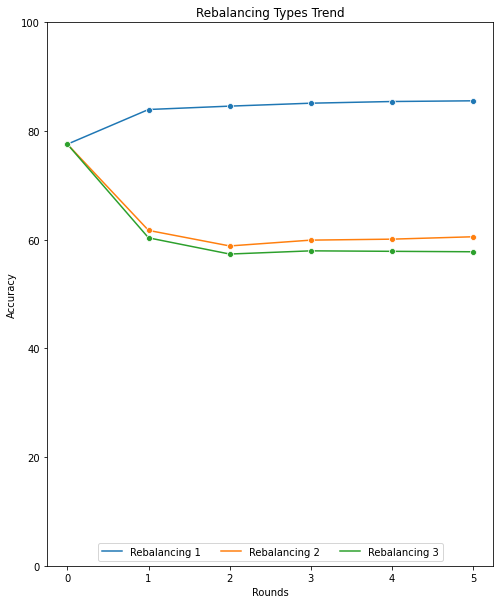

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 10))

sns.lineplot(data=reb_types, x='Rounds', y="Accuracy", hue='Rebalancing', marker='o', ax=ax).set(title='Rebalancing Types Trend')

plt.legend(loc="lower center", ncol=3)
plt.ylim(0,100)
plt.show()